# ResultAnalysis
Notebook to check Grid Search results

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/Users/tales.pimentel/ds/kaggle/football-match-prediction'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from src.dao import dao_ml
from src.utils import dflib, stats, pretties, plot, plot_domain, palette

In [3]:
pretties.max_data_frame_columns()

# Loading Results

In [4]:
all_results = dao_ml.load_all_modeling()
print(len(all_results))

all_results_df = pd.DataFrame(all_results)
all_results_df["undersampling"] = all_results_df["pipeline_train_stages"].apply(lambda ppl : "UndersamplingTransformer" in ppl)

all_results_df["undersampling"] = all_results_df["undersampling"].replace({True: "balanced", False: "no"})

all_results_df["features"] = all_results_df["feature_importances"].apply(lambda fi : list(fi["importance"].keys()))
all_results_df["n_features"] = all_results_df["features"].apply(len)

6


In [5]:
all_results_df[["id_modeling", "datetime", "clf_name", "undersampling", "n_features",
                 "best_score_cv_train", "best_score_cv", "clf_params", "features", "id_data"]].sort_values("best_score_cv", ascending=True)

,id_modeling,datetime,clf_name,undersampling,n_features,best_score_cv_train,best_score_cv,clf_params,features,id_data
3,b261bebf-e056-4c9f-b40e-b5b019613c2b,2022-05-27 05:02:13,RandomForestClassificationModel,balanced,7,0.999287,1.000171,"{'numTrees': 60, 'maxDepth': 10, 'subsamplingR...","[home_mood_diff, draw_factor, away_history_moo...",04a4d619-00cc-4484-a724-e27e2161c91d
4,39f825ce-4edc-4227-b69e-f353357b87d1,2022-05-27 17:27:36,LGBMClassifier,no,7,0.997671,1.010027,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...","[home_mood_diff, home_factor, draw_factor, awa...",04a4d619-00cc-4484-a724-e27e2161c91d
5,7fb951d1-4a95-4210-9d2a-1b34674ff279,2022-05-27 10:42:58,XGBClassifier,no,7,1.005677,1.010452,"{'colsample_bytree': 0.6, 'max_depth': 2, 'n_e...","[home_mood_diff, home_history_mood_mean, draw_...",04a4d619-00cc-4484-a724-e27e2161c91d
0,62e46782-8f32-488e-9fec-19923681d8ea,2022-05-26 21:04:41,RandomForestClassificationModel,no,7,0.981549,1.012594,"{'numTrees': 60, 'maxDepth': 10, 'subsamplingR...","[home_mood_diff, home_history_mood_mean, away_...",04a4d619-00cc-4484-a724-e27e2161c91d
1,a7c53082-93af-4eb7-ab90-f942c94c9dbf,2022-05-27 18:05:41,LGBMClassifier,balanced,7,1.029246,1.039577,"{'colsample_bytree': 0.5, 'learning_rate': 0.2...","[home_mood_diff, home_factor, draw_factor, hom...",04a4d619-00cc-4484-a724-e27e2161c91d
2,dfa5e718-a52e-442d-8c2a-7839f701305d,2022-05-27 10:09:20,XGBClassifier,balanced,7,1.033616,1.039655,"{'colsample_bytree': 0.6, 'max_depth': 2, 'n_e...","[home_mood_diff, draw_factor, away_result_hist...",04a4d619-00cc-4484-a724-e27e2161c91d


# Select id_modeling

In [6]:
load_ids_modeling = ["62e46782-8f32-488e-9fec-19923681d8ea",
                     "7fb951d1-4a95-4210-9d2a-1b34674ff279", 
                     "39f825ce-4edc-4227-b69e-f353357b87d1"]

rdf = pd.DataFrame()

for id_modeling in load_ids_modeling:
    results_temp = dao_ml.load_modeling(id_modeling)
    
    rdf_id = pd.DataFrame(results_temp["overfitting_analysis_df"])
    rdf_id["clf_name"] = results_temp["clf_name"]
    
    rdf = rdf.append(rdf_id)

In [7]:
rdf = rdf.sort_values("log_loss_cv")
rdf.head(5)

,log_loss_train,log_loss_cv,numTrees,maxDepth,subsamplingRate,clf_name,colsample_bytree,max_depth,n_estimators,subsample,std_train_log_loss,std_cv_log_loss,learning_rate,num_leaves
505,0.997671,1.010027,NaN,NaN,NaN,LGBMClassifier,0.7,5.0,60.0,0.6,0.000418,0.003943,0.1,20.0
504,0.997671,1.010027,NaN,NaN,NaN,LGBMClassifier,0.7,5.0,60.0,0.5,0.000418,0.003943,0.1,20.0
506,0.997671,1.010027,NaN,NaN,NaN,LGBMClassifier,0.7,5.0,60.0,0.7,0.000418,0.003943,0.1,20.0
531,0.996396,1.010056,NaN,NaN,NaN,LGBMClassifier,0.7,-1.0,60.0,0.5,0.000439,0.003733,0.1,20.0
533,0.996396,1.010056,NaN,NaN,NaN,LGBMClassifier,0.7,-1.0,60.0,0.7,0.000439,0.003733,0.1,20.0


In [8]:
def overfitting_analysis_num(metrics_df, param_name, metric_colname):
    metric_colname_train = metric_colname + "_train"
    metric_colname_valid = metric_colname + "_cv"
    
    of_data = metrics_df.groupby(param_name)[[metric_colname_train, metric_colname_valid]].mean().reset_index()

    display(of_data)
    
    title = f"{metric_colname} mean values for {param_name}"
    
    plt.figure(figsize=(8,5))
    plt.scatter(of_data[param_name], of_data[metric_colname_train], label="train", s=130, alpha=0.6)
    plt.scatter(of_data[param_name], of_data[metric_colname_valid], label="cv", s=130, alpha=0.6)
    plt.title(label=title)
    plt.xlabel(param_name)
    plt.ylabel(metric_colname)
    plt.legend()
    plt.show()

# <font color=blue>RandomForestClassificationModel</font>

#### <font color=black>subsamplingRate</font>

,subsamplingRate,log_loss_train,log_loss_cv
0,0.5,1.007691,1.018678
1,0.6,1.007674,1.018816
2,0.7,1.007635,1.018865


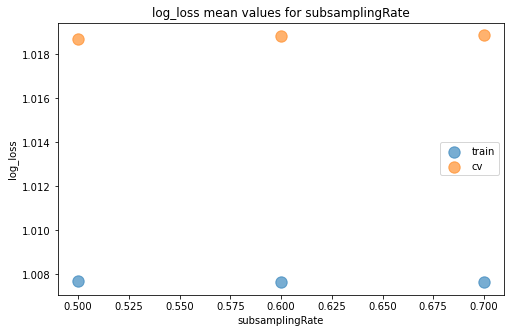

#### <font color=black>maxDepth</font>

,maxDepth,log_loss_train,log_loss_cv
0,4.0,1.028799,1.029445
1,6.0,1.016651,1.018983
2,8.0,1.003987,1.013795
3,10.0,0.981230,1.012922


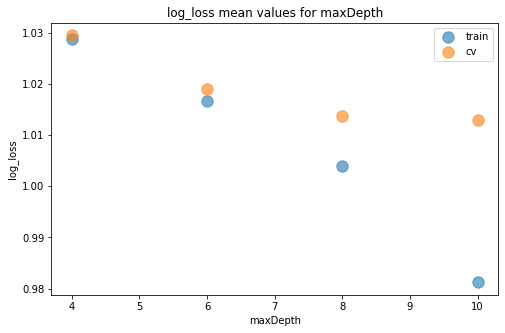

#### <font color=black>numTrees</font>

,numTrees,log_loss_train,log_loss_cv
0,40.0,1.007849,1.018986
1,60.0,1.007484,1.018586


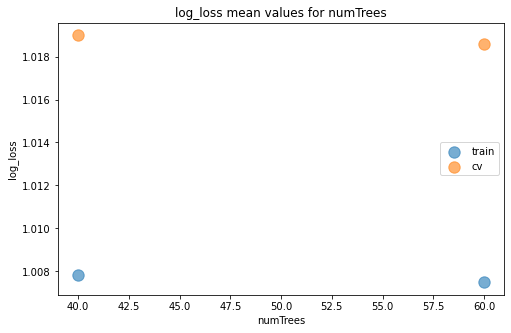

In [9]:
pretties.md("RandomForestClassificationModel", size="#", color="blue")
rfc_df = rdf[rdf["clf_name"] == "RandomForestClassificationModel"]

for param_name in ["subsamplingRate", "maxDepth", "numTrees"]:
    pretties.md(param_name, size="####")
    overfitting_analysis_num(metrics_df=rfc_df, 
                             param_name=param_name, 
                             metric_colname="log_loss")

# <font color=blue>XGBClassifier</font>

#### <font color=black>colsample_bytree</font>

,colsample_bytree,log_loss_train,log_loss_cv
0,0.5,0.999841,1.013090
1,0.6,0.998786,1.012899
2,0.7,0.998786,1.012899


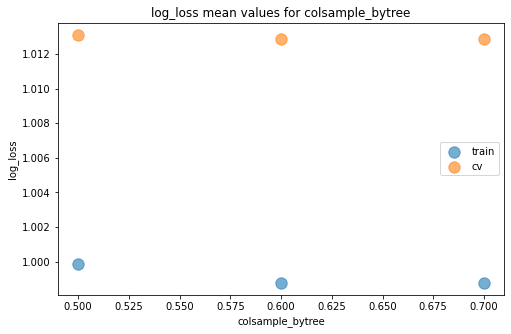

#### <font color=black>max_depth</font>

,max_depth,log_loss_train,log_loss_cv
0,1.0,1.013397,1.015305
1,2.0,1.008115,1.011750
2,4.0,0.998184,1.011116
3,6.0,0.976854,1.013680


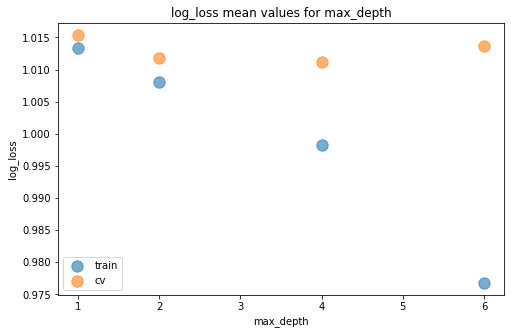

#### <font color=black>n_estimators</font>

,n_estimators,log_loss_train,log_loss_cv
0,20.0,1.005530,1.013944
1,40.0,0.998418,1.012465
2,60.0,0.993466,1.012479


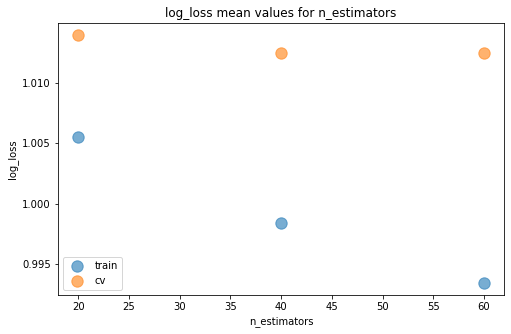

#### <font color=black>subsample</font>

,subsample,log_loss_train,log_loss_cv
0,0.6,0.999429,1.013107
1,0.7,0.999107,1.012861
2,0.8,0.998877,1.012920


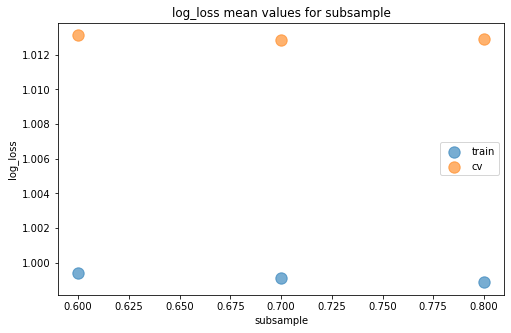

In [10]:
pretties.md("XGBClassifier", size="#", color="blue")
xgbc_df = rdf[rdf["clf_name"] == "XGBClassifier"]

for param_name in ["colsample_bytree", "max_depth", "n_estimators", "subsample"]:
    pretties.md(param_name, size="####")
    overfitting_analysis_num(metrics_df=xgbc_df, 
                             param_name=param_name, 
                             metric_colname="log_loss")

# <font color=blue>LGBMClassifier</font>

#### <font color=black>num_leaves</font>

,num_leaves,log_loss_train,log_loss_cv
0,20.0,1.003520,1.013379
1,31.0,1.000596,1.013614
2,40.0,0.999059,1.013738


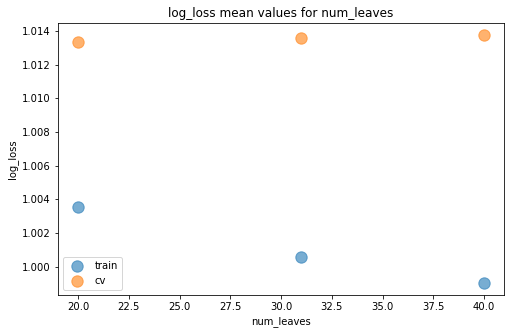

#### <font color=black>max_depth</font>

,max_depth,log_loss_train,log_loss_cv
0,-1.0,0.987903,1.012392
1,1.0,1.016382,1.018085
2,3.0,1.005939,1.011908
3,5.0,0.994010,1.011923


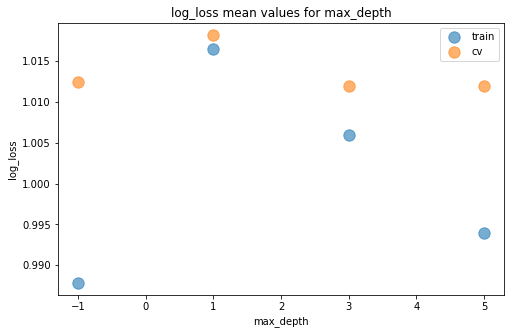

#### <font color=black>colsample_bytree</font>

,colsample_bytree,log_loss_train,log_loss_cv
0,0.5,1.001308,1.013634
1,0.6,1.001308,1.013634
2,0.7,1.000560,1.013462


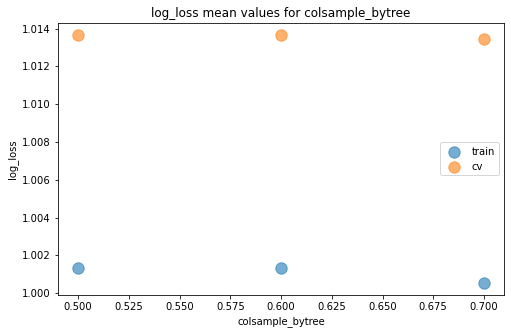

#### <font color=black>subsample</font>

,subsample,log_loss_train,log_loss_cv
0,0.5,1.001059,1.013577
1,0.6,1.001059,1.013577
2,0.7,1.001059,1.013577


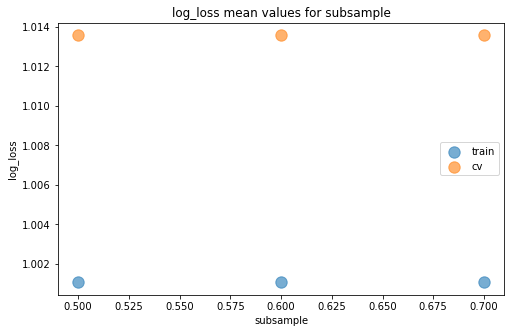

#### <font color=black>n_estimators</font>

,n_estimators,log_loss_train,log_loss_cv
0,20.0,1.008023,1.015415
1,40.0,1.000142,1.012799
2,60.0,0.995011,1.012517


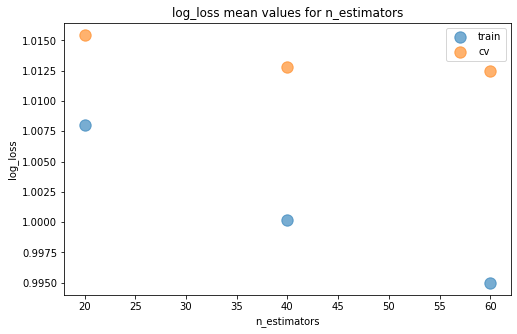

#### <font color=black>learning_rate</font>

,learning_rate,log_loss_train,log_loss_cv
0,0.1,1.007223,1.014506
1,0.3,0.994894,1.012648


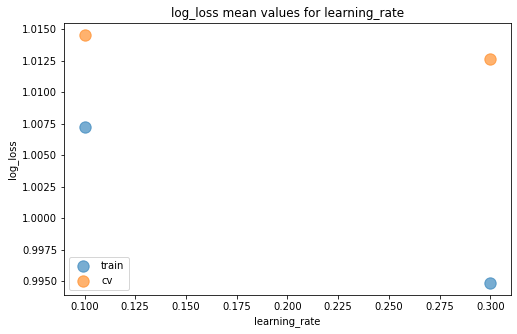

In [11]:
pretties.md("LGBMClassifier", size="#", color="blue")
xgbc_df = rdf[rdf["clf_name"] == "LGBMClassifier"]

for param_name in ["num_leaves", "max_depth", "colsample_bytree", "subsample", "n_estimators", "learning_rate"]:
    pretties.md(param_name, size="####")
    overfitting_analysis_num(metrics_df=xgbc_df, 
                             param_name=param_name, 
                             metric_colname="log_loss")
